<a href="https://colab.research.google.com/github/Sahel-Eskandar/Term-Deposit/blob/main/Notebook/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Term Deposit Subscription 


## Introduction
[Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing) used for this project is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.
This data set includes data from 2008 to 2013.

1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar', 'entrepreneur','housemaid','management', 'retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course', 'university.degree', 'unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown') # related with the last contact of the current campaign:
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no')
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') # social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric) Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no') 

##Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install --upgrade pyod

In [3]:
import os, sys
import os.path

import math
import time
from datetime import datetime as dt
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
import numpy as np
import pandas as pd
import seaborn as sns
import random

import warnings
warnings.simplefilter('ignore')
sns.set_style('whitegrid') # style
# render plots inline
%matplotlib inline

In [24]:
sns.set_style('ticks')
plt.style.use('seaborn-colorblind')

In [4]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

#Data Extraction
First, data was loaded to study the number of observations and features

In [5]:
path = 'https://raw.githubusercontent.com/Sahel-Eskandar/Term-Deposit/main/Data/term_deposit_data.csv'
df = pd.read_csv(path, sep= ';')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [7]:
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [9]:
# Explore the NAs
#Make a copy of dataset for that
dat_NA = df.copy()
# Substitute unknowns in the dataset with NA
NA = dat_NA[dat_NA == "unknown"]

In [10]:
NA_Val = 100*NA.count()/len(NA)
NA_Val

age                0.000000
job                0.801204
marital            0.194231
education          4.202680
default           20.872584
housing            2.403613
loan               2.403613
contact            0.000000
month              0.000000
day_of_week        0.000000
duration           0.000000
campaign           0.000000
pdays              0.000000
previous           0.000000
poutcome           0.000000
emp.var.rate       0.000000
cons.price.idx     0.000000
cons.conf.idx      0.000000
euribor3m          0.000000
nr.employed        0.000000
y                  0.000000
dtype: float64

In [11]:
Y_Val = NA_Val.sort_values(axis=0, ascending= False)
Y_Val
Y_Val.index

Index(['default', 'education', 'housing', 'loan', 'job', 'marital', 'age',
       'poutcome', 'nr.employed', 'euribor3m', 'cons.conf.idx',
       'cons.price.idx', 'emp.var.rate', 'duration', 'previous', 'pdays',
       'campaign', 'day_of_week', 'month', 'contact', 'y'],
      dtype='object')

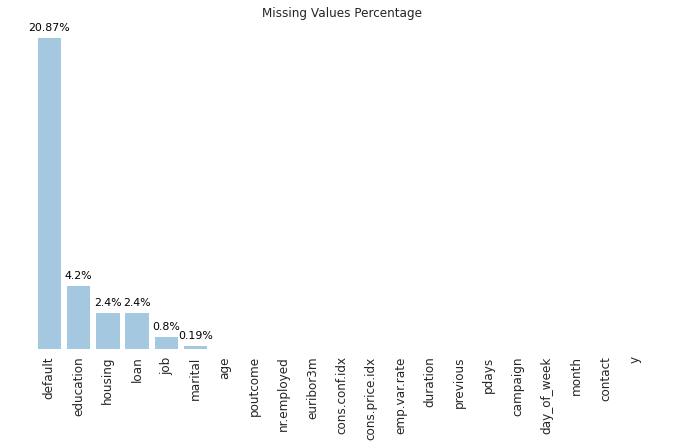

In [15]:
plt.figure(figsize=(12,6))
bars = plt.bar(x = Y_Val.index, height= Y_Val, align='center', linewidth=0, color = '#1F77B4', alpha=0.4)
# xlabel = 'Features',ylabel='Proportion of missing data')
plt.grid(False)
F = plt.gca()
for spine in F.spines.values():
    spine.set_visible(False)
plt.yticks([])
plt.title('Missing Values Percentage')
x = F.xaxis
for item in x.get_ticklabels():
    item.set_rotation(90)
    item.set_fontsize(12)
for bar in bars[:6]:
    height = bar.get_height()
    F.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.5, str(round(height,2))+'%',
                   ha='center', color='black', fontsize=11)

In [ ]:
#F.get_children()
#plt.get_backend()

In [16]:
Y_Val = df.y.value_counts()
Y_Val

no     36548
yes     4640
Name: y, dtype: int64

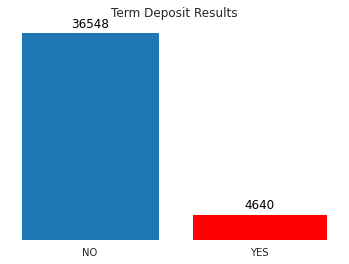

In [17]:
Y_Val = df.y.value_counts()
plt.figure(figsize=(6,4))
bars = plt.bar(x = ['NO', 'YES'], height= Y_Val, align='center', linewidth=1 ,color = ['blue','red'])
bars[0].set_color('#1F77B4')
plt.grid(False)
plt.title('Term Deposit Results')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])
for bar in bars:
    # Unfortunately, this means doing
    # a little bit of playing with padding.
    # Here I'll set up the x location to the bar
    # x plus the width divided by two and
    # the y location to be
    # the bar height minus five.

    # It might seem weird to get the middle
    # of the bar in the x dimension, but
    # that's because I'm setting the label
    # to center itself, horizontally.

    height = bar.get_height()
    plt.gca().text(bar.get_x() + bar.get_width() / 2, bar.get_height()+1000, str(int(height)),
                   ha='center', color='black', fontsize=12)

#Data Visualization

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'campaign'}>],
       [<AxesSubplot:title={'center':'pdays'}>,
        <AxesSubplot:title={'center':'previous'}>,
        <AxesSubplot:title={'center':'emp.var.rate'}>],
       [<AxesSubplot:title={'center':'cons.price.idx'}>,
        <AxesSubplot:title={'center':'cons.conf.idx'}>,
        <AxesSubplot:title={'center':'euribor3m'}>],
       [<AxesSubplot:title={'center':'nr.employed'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

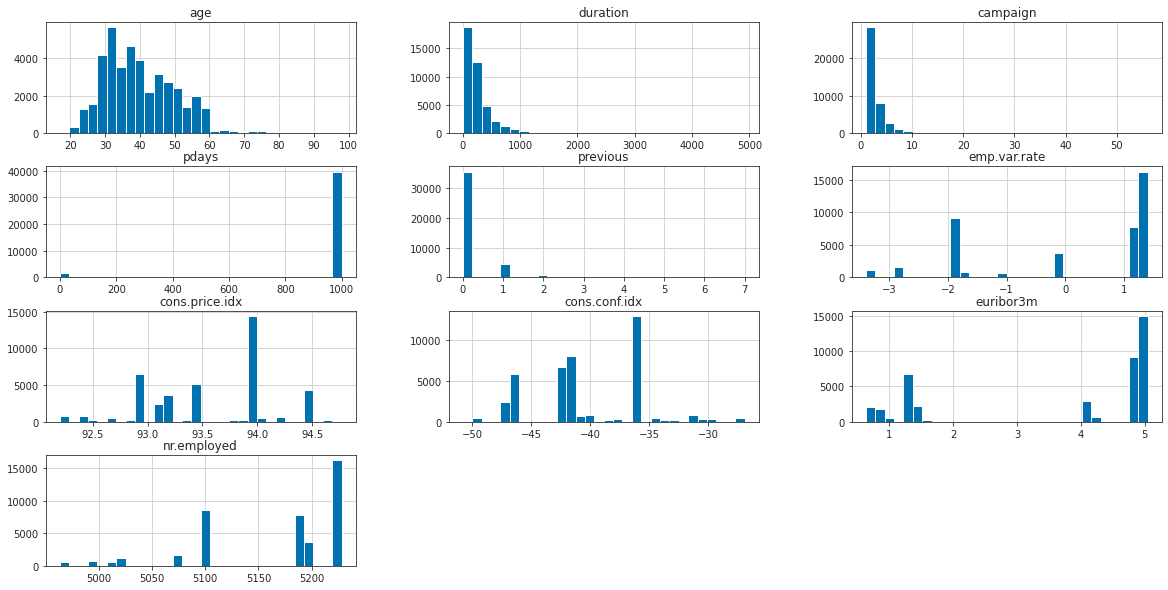

In [29]:
df.hist(bins= 30, figsize=(20, 10));
#plt.show()

Pair-plot

Pair plots are a combination of scatter plots and histograms.

They are done for each pair of features (e.g. age vs. job)

https://seaborn.pydata.org/generated/seaborn.pairplot.html

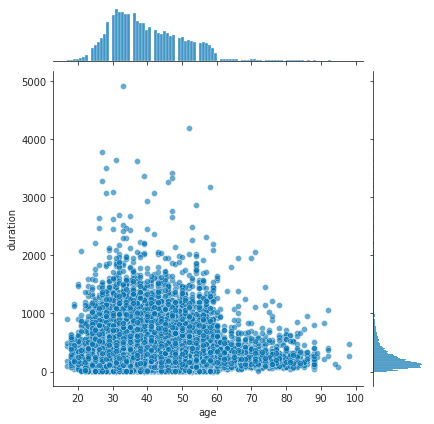

In [26]:
sns.jointplot(x=df.age, y=df.duration, alpha=0.6);

In [ ]:
sns.set_style('white')

sns.jointplot(x=df.age, y=df.campaign, kind='kde', space=0);

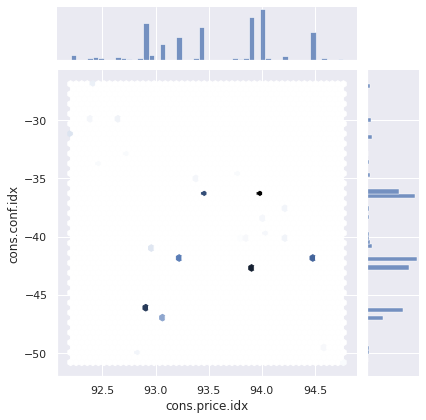

In [35]:
sns.jointplot(x=df['cons.price.idx'], y=df['cons.conf.idx'],  kind='hex');

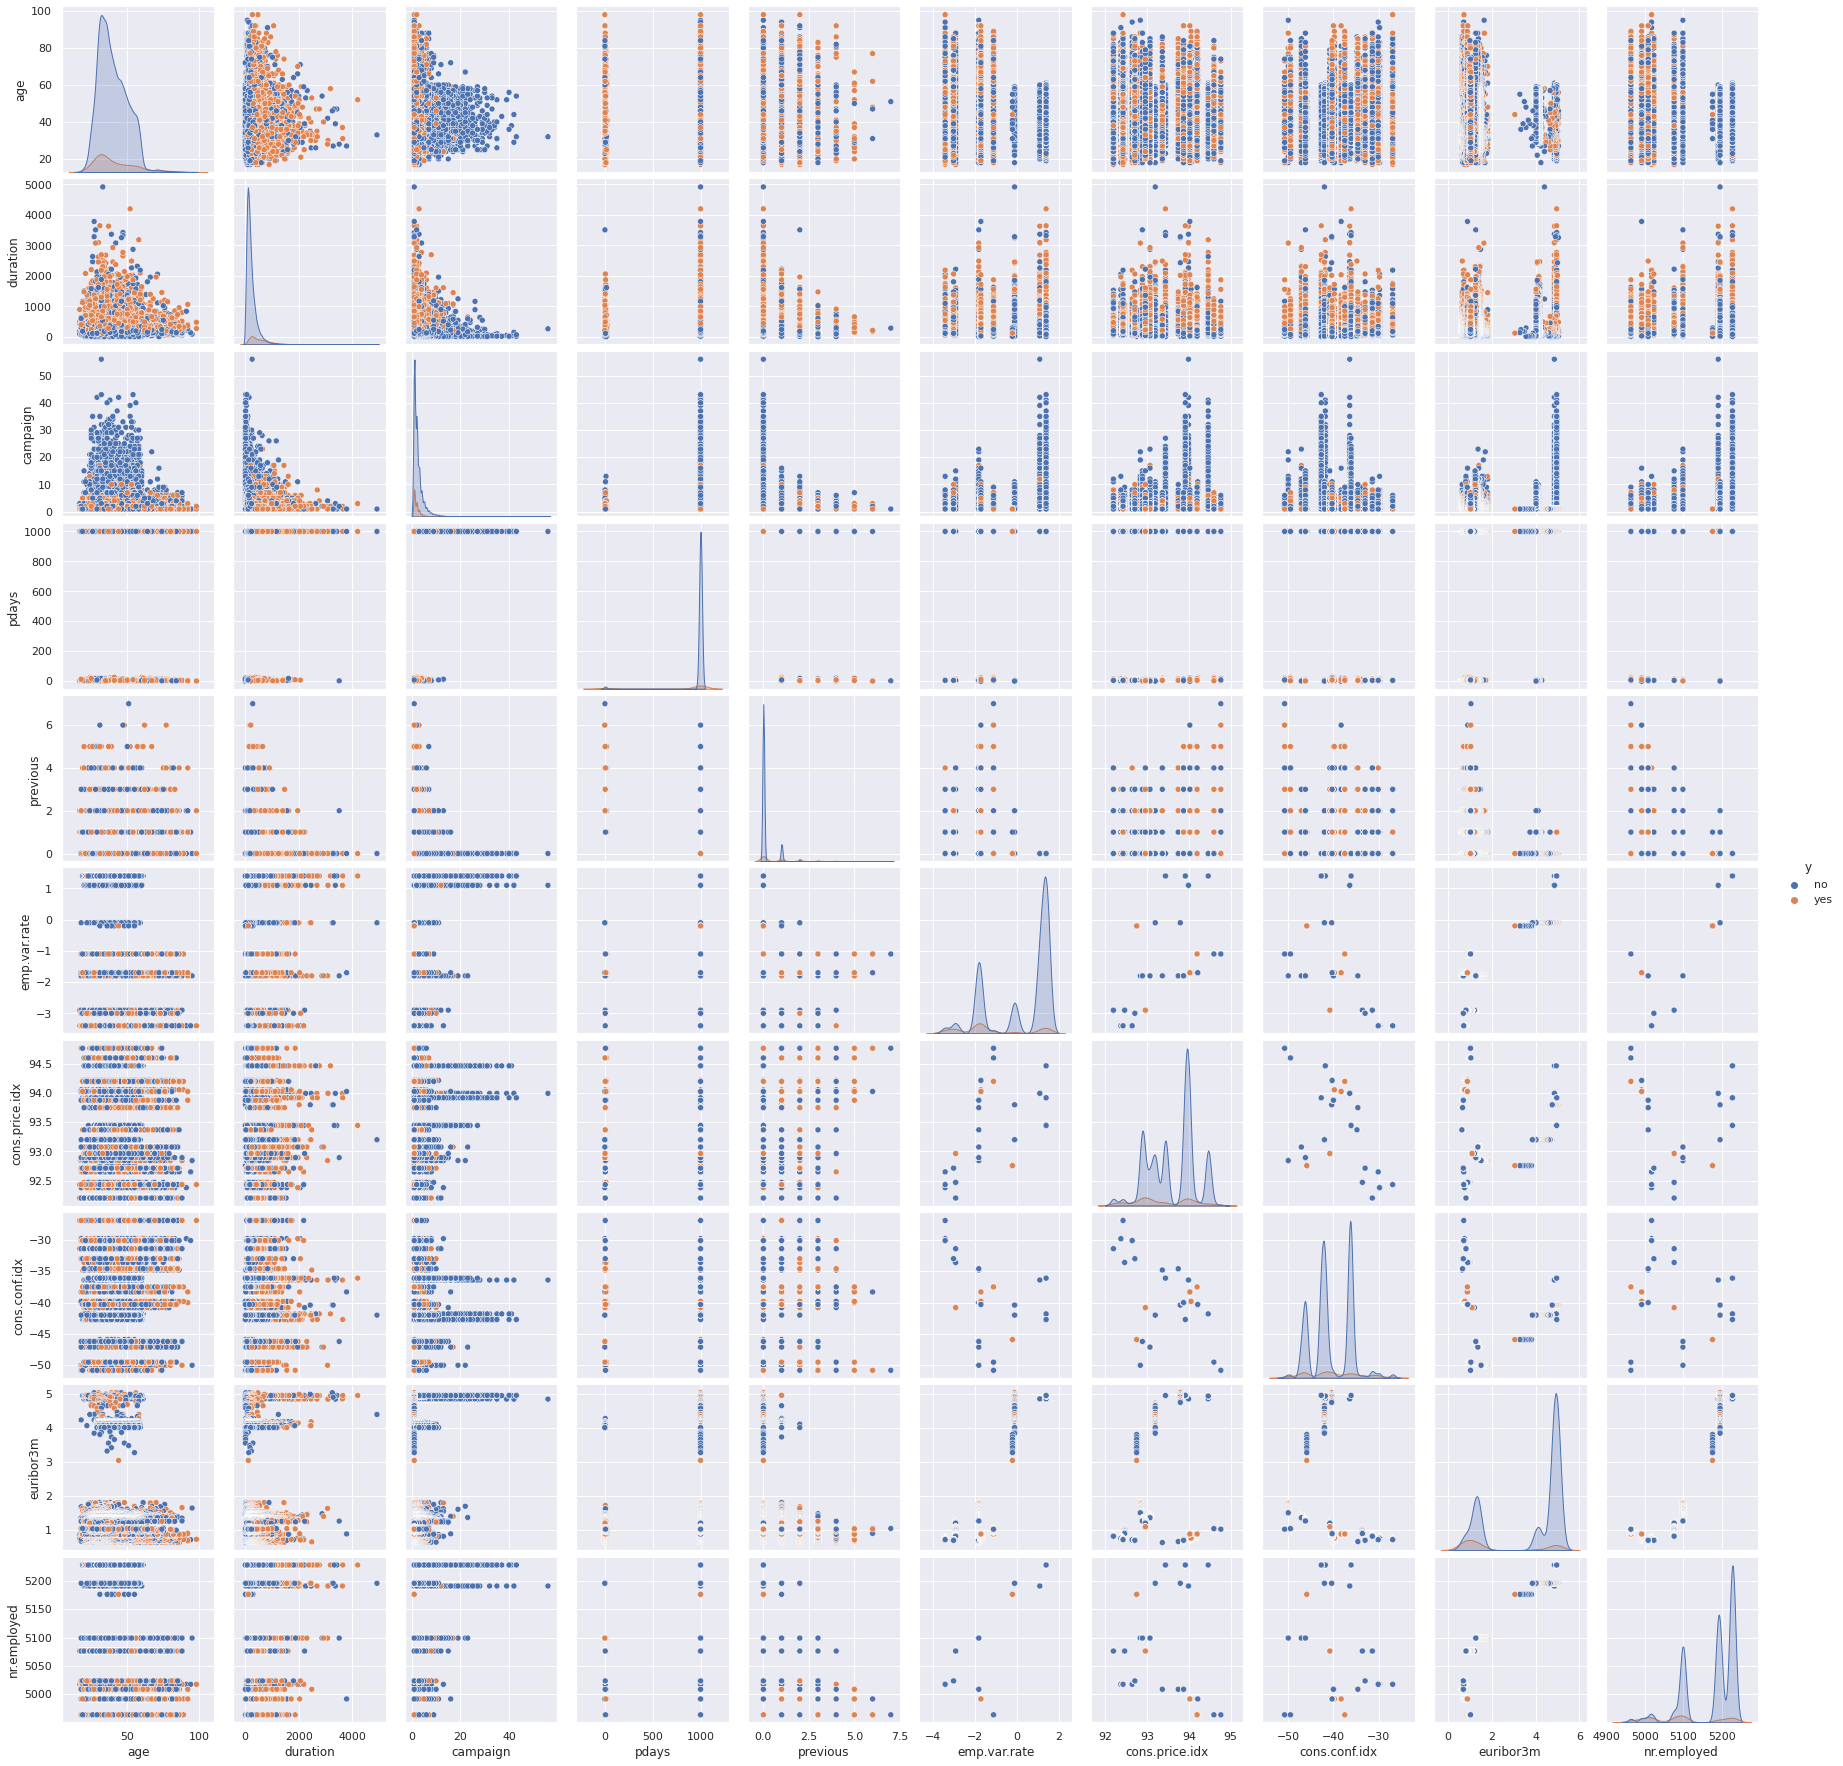

In [34]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(30,30)})
sns.pairplot(df,hue="y");
#plt.show()

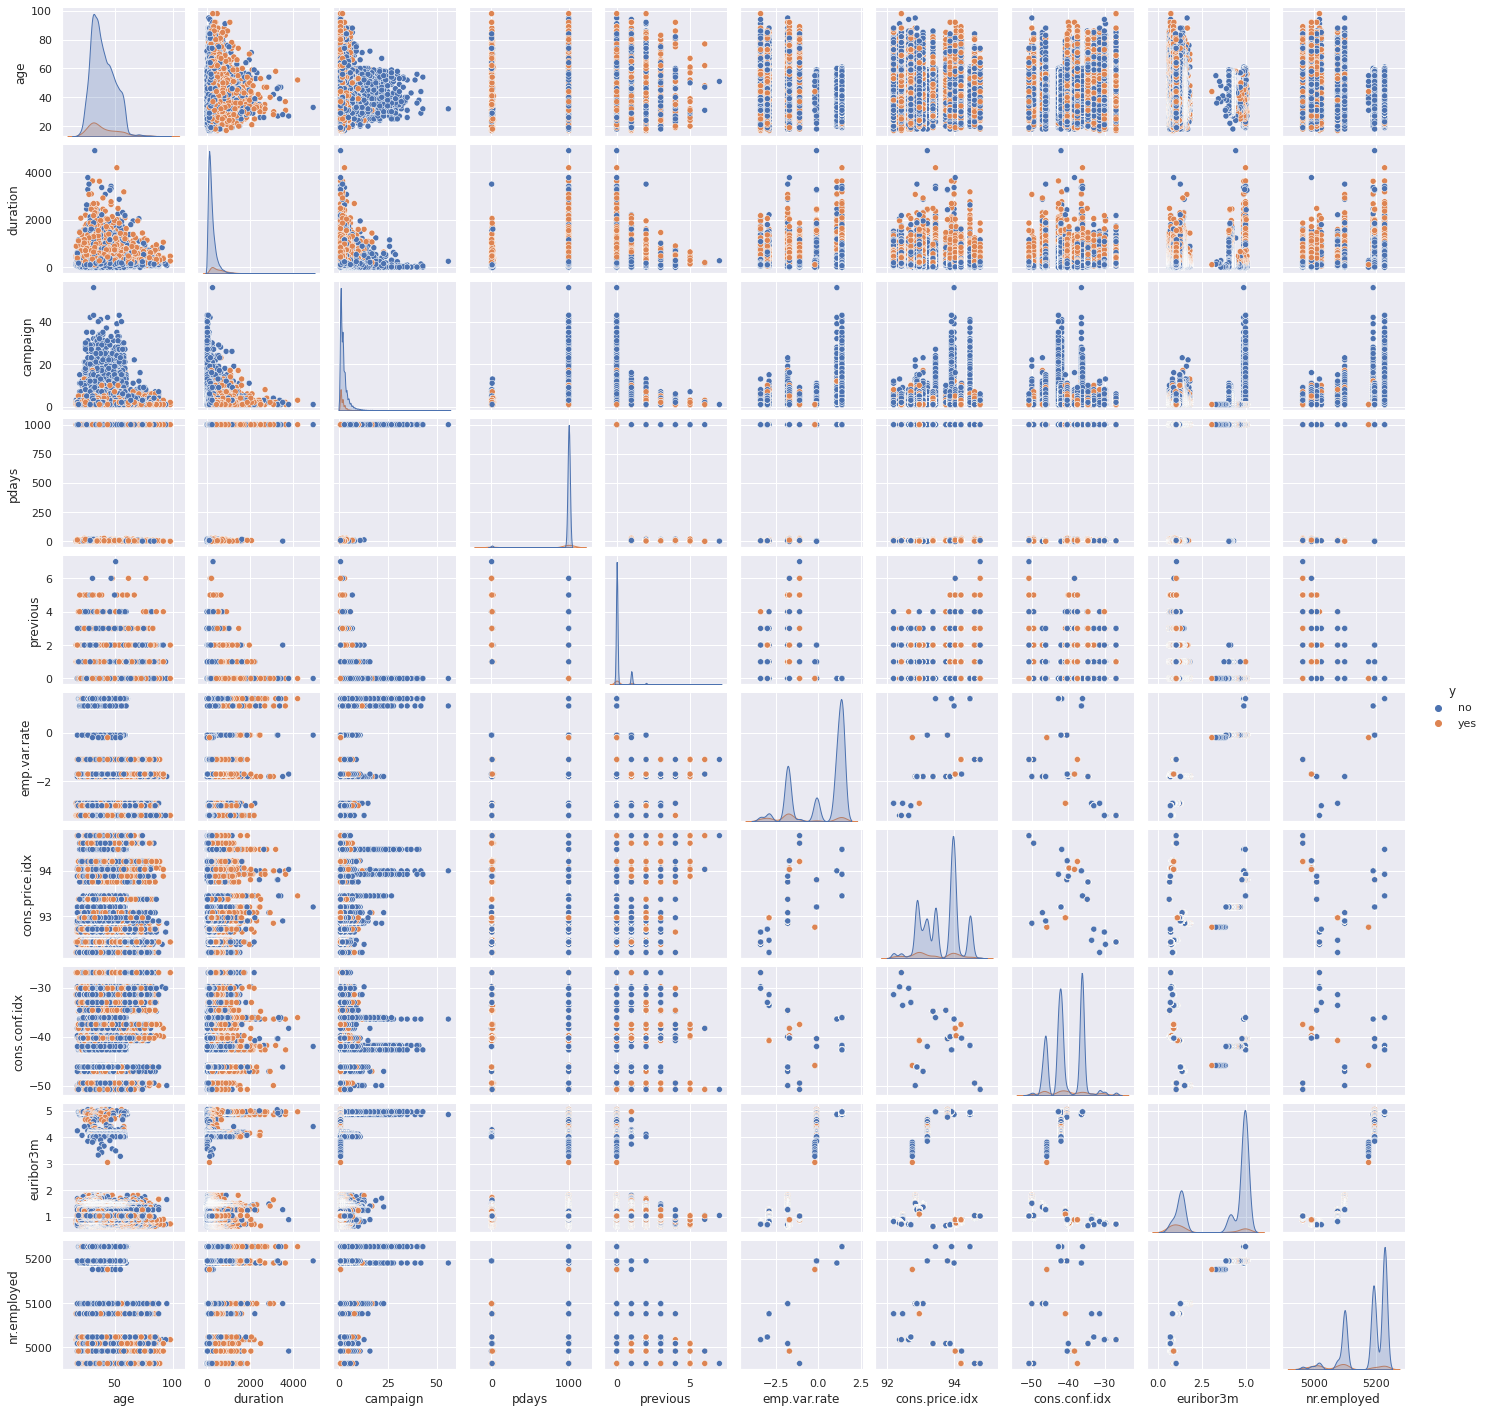

In [36]:
df.drop(columns=['pdays','previous'],axis=1)
sns.pairplot(df, hue='y', diag_kind='kde', height=2);

Correlation

Correlations provide a metric to indicate whether two variables are strongly dependent.

https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/

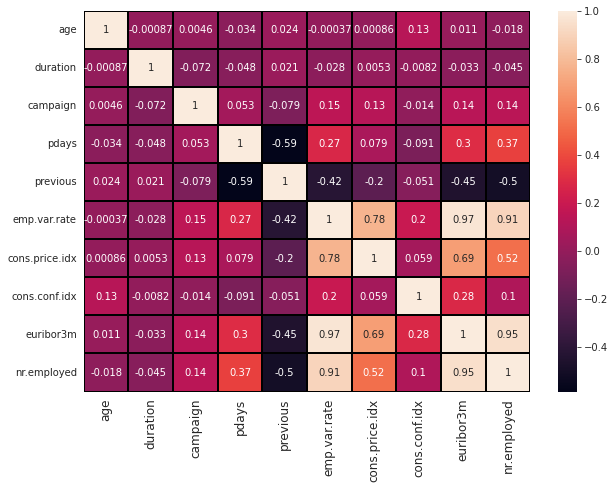

In [ ]:
df.corr(method='pearson')
# a graphical way to viewing the correlation matrix
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(df.corr(method='pearson'), annot=True, fmt='.2g',
            annot_kws=None, linewidths=1, linecolor='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.show()

Drop one of the features of those highly correlated. Normally with high correlation (>0.8) and almost zero correlation there are issues.

features 'emp.var.rate' and 'euribor3m' were selected based on the correlation matrix and kbest feature analysis

In [ ]:
remove_cols = ['emp.var.rate','euribor3m']
df2 = df.drop(remove_cols, axis= 1)
#euribor3m nr.employed emp.var.rate

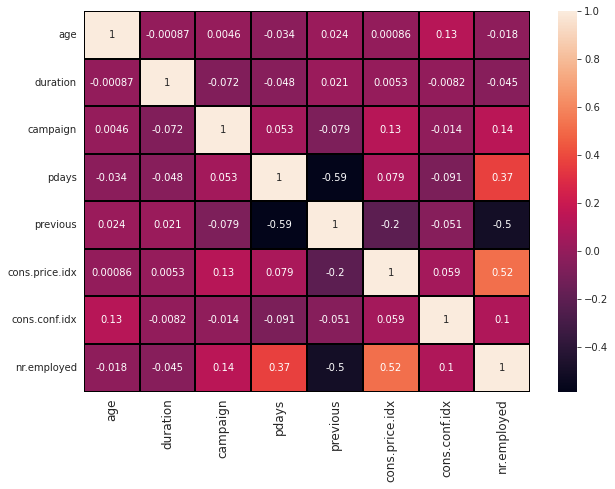

In [ ]:
df2.corr(method='pearson')
# a graphical way to viewing the correlation matrix
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(df2.corr(method='pearson'), annot=True, fmt='.2g',
            annot_kws=None, linewidths=1, linecolor='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
marital_percent = pd.crosstab(df['marital'], df['y']).apply(lambda x: x/x.sum() * 100)
marital_percent.sort_values(by='yes', ascending=False)

y,no,yes
marital,,
married,61.278319,54.568966
single,27.219000,34.913793
divorced,11.316625,10.258621
unknown,0.186057,0.258621


In [ ]:
contact_percent = pd.crosstab(df['contact'], df['y']).apply(lambda x: x/x.sum() * 100)
contact_percent.sort_values(by='yes', ascending=False)

y,no,yes
contact,,
cellular,60.991026,83.038793
telephone,39.008974,16.961207


In [ ]:
df.contact.value_counts()

cellular     26144
telephone    15044
Name: contact, dtype: int64

In [ ]:
month_percent = pd.crosstab(df['month'], df['y']).apply(lambda x: x/x.sum() * 100)
month_percent.sort_values(by='yes', ascending=False)

y,no,yes
month,,
may,35.249535,19.094828
aug,15.111634,14.116379
jul,17.853234,13.987069
jun,13.021232,12.047414
apr,5.726716,11.616379
nov,10.082631,8.965517
oct,1.102660,6.788793
mar,0.738755,5.948276
sep,0.859144,5.517241


In [ ]:
job_percent = pd.crosstab(df['job'], df['y']).apply(lambda x: x/x.sum() * 100)
job_percent.sort_values(by='yes', ascending=False)

y,no,yes
job,,
admin.,24.816679,29.137931
technician,16.452337,15.732759
blue-collar,23.574477,13.750000
retired,3.518660,9.353448
management,7.102988,7.068966
services,9.975922,6.961207
student,1.641677,5.926724
self-employed,3.480355,3.211207
unemployed,2.380431,3.103448


In [ ]:
df['job'].replace({'entrepreneur': 'self-employed', 'technician': 'blue-collar',
                   'admin.': 'white-collar', 'management': 'white-collar',
                  'services': 'pink-collar', 'housemaid': 'pink-collar'}, inplace=True)

In [ ]:
df['job'].value_counts()

blue-collar      15997
white-collar     13346
pink-collar       5029
self-employed     2877
retired           1720
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [ ]:
education_percent = pd.crosstab(df['education'], df['y']).apply(lambda x: x/x.sum() * 100)
education_percent.sort_values(by='yes', ascending=False)

y,no,yes
education,,
university.degree,28.723870,35.991379
high.school,23.213309,22.219828
professional.course,12.717522,12.823276
basic.9y,15.245704,10.193966
basic.4y,10.255007,9.224138
unknown,4.049469,5.409483
basic.6y,5.756813,4.051724
illiterate,0.038306,0.086207


In [ ]:
df['education'].replace({'basic.9y': 'basic','basic.4y': 'basic','basic.6y':'basic'},inplace=True)

In [ ]:
df['education'].value_counts()

basic                  12513
university.degree      12168
high.school             9515
professional.course     5243
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [ ]:
df.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

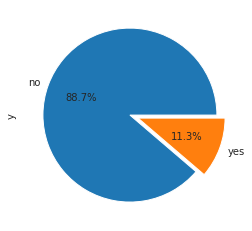

In [ ]:
X = df.y.value_counts()
f,ax=plt.subplots(1,1, figsize=(6,4))
X.plot.pie(explode=[0,0.1],autopct='%1.1f%%')
plt.show()

Shows impalance data.

In [ ]:
cd '/content/Interview/'

/content/Interview


In [ ]:
!git add '/content/Interview/Data'
!git commit -m 'Aviva'  # commit in Colab
!git push origin main

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date


#Data Prepration

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder,LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from keras.utils.np_utils import to_categorical
from pyod.models.knn import KNN
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR

In [ ]:
df_enc = df.copy()

In [ ]:
numerical_cols = df_enc.select_dtypes(include=['float64', 'int64']).columns

In [ ]:
df_enc['y'] = np.where(df_enc.y == 'yes', 1, 0)

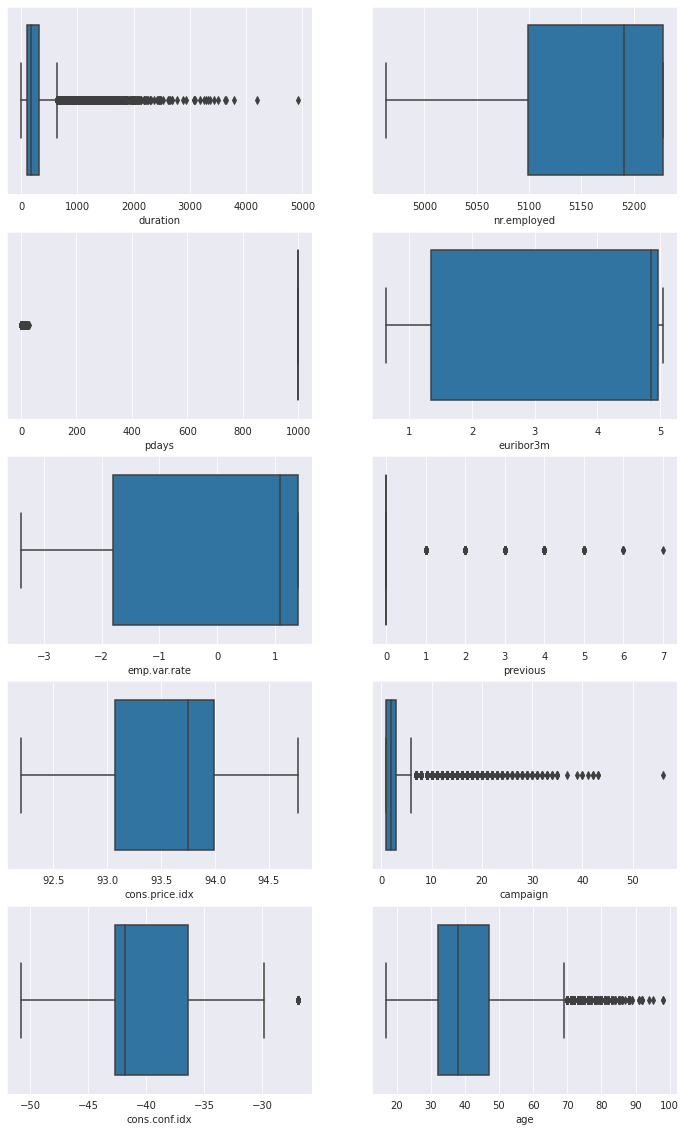

In [ ]:
corr = df_enc.corr()['y'].abs().sort_values(ascending=False)
cols = corr[corr < 1].index.tolist()
sns.set_style('darkgrid')
fig , ax = plt.subplots(5,2,figsize = (12,20))
ax = ax.ravel()
for i,col in enumerate(cols):
    sns.boxplot(df_enc[col], ax = ax[i])

In [ ]:
df_enc.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,pink-collar,married,basic,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,pink-collar,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,pink-collar,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,white-collar,married,basic,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,pink-collar,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [ ]:
col_list = df_enc.select_dtypes(include = "object").columns
print(col_list)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')


##Encoding

Using OneHotEncoding: pd.get_dummies

In [ ]:
df_enc= pd.get_dummies(df_enc, columns=col_list)
df_enc.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0


##Label Encoding for featur selection
The goal is keeping the features with higher correlation with the 'y' feature. Also removing those of highly correlated that were detected in matrix correlation 

In [ ]:
le = LabelEncoder()
for colsn in col_list:
    df[colsn] = le.fit_transform(df[colsn])

In [ ]:
candidate_features = df.columns.drop(['y'])
candidate_features.values

array(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'], dtype=object)

In [ ]:
kbest = SelectKBest(k=16, score_func=f_classif)
kbest.fit(df.loc[:, candidate_features], df.y)
kbest.scores_

array([3.80946593e+01, 1.34624937e+02, 8.81070467e+01, 1.64283651e+02,
       4.10590785e+02, 5.49665339e+00, 9.92371254e-01, 8.81707070e+02,
       1.51493970e+00, 1.05030959e+01, 8.09410163e+03, 1.82156673e+02,
       4.86117327e+03, 2.30425709e+03, 7.05678164e+02, 4.02382993e+03,
       7.78589795e+02, 1.24409975e+02, 4.30947905e+03, 5.92661060e+03])

In [ ]:
kbestfeatures = pd.DataFrame({'feature':candidate_features.values,'score':kbest.scores_})
kbestfeatures.set_index('feature',inplace=True)
kbestfeatures.sort_values(by='score', ascending=False)

,score
feature,
duration,8094.101634
nr.employed,5926.610601
pdays,4861.173272
euribor3m,4309.479048
emp.var.rate,4023.829925
previous,2304.257088
contact,881.707070
cons.price.idx,778.589795
poutcome,705.678164


Selected features base on the kbest method are:

In [ ]:
selected_features = candidate_features[kbest.get_support()]
selected_features = selected_features.insert(15,'y')
selected_features

Index(['age', 'job', 'marital', 'education', 'default', 'contact', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'y', 'nr.employed'],
      dtype='object')

In [ ]:
candidate_features

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [ ]:
numerical_cols

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [ ]:
result_1 = list(set(candidate_features).difference(selected_features))
print(result_1)

['loan', 'day_of_week', 'housing', 'month']


##KNN sample selection

In [ ]:
x = df_enc[cols].values
model = KNN(contamination=.1)
model.fit(x)
predicted = model.predict(x)

outliers = df_enc.loc[(predicted == 1),:]
inliers = df_enc.loc[(predicted == 0),:]

In [ ]:
df_enc = df_enc.drop(index = df_enc.loc[(predicted == 1),:].index )
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37600 entries, 0 to 41180
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            37600 non-null  int64  
 1   duration                       37600 non-null  int64  
 2   campaign                       37600 non-null  int64  
 3   pdays                          37600 non-null  int64  
 4   previous                       37600 non-null  int64  
 5   emp.var.rate                   37600 non-null  float64
 6   cons.price.idx                 37600 non-null  float64
 7   cons.conf.idx                  37600 non-null  float64
 8   euribor3m                      37600 non-null  float64
 9   nr.employed                    37600 non-null  float64
 10  y                              37600 non-null  int64  
 11  job_blue-collar                37600 non-null  uint8  
 12  job_pink-collar                37600 non-null 

In [ ]:
#standard Scaler for Numerical Variables
# normalize data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,Normalizer
rr = RobustScaler()
ss = StandardScaler()
mm = MinMaxScaler()
nn = Normalizer()

scaler = ss


df_enc[numerical_cols] = scaler.fit_transform(df_enc[numerical_cols])

In [ ]:
df_enc.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,1.734565,0.165454,-0.602919,0.076012,-0.315927,0.579505,0.728214,0.966856,0.642695,0.224755,...,0,0,0,1,0,0,0,0,1,0
1,1.839917,-0.407251,-0.602919,0.076012,-0.315927,0.579505,0.728214,0.966856,0.642695,0.224755,...,0,0,0,1,0,0,0,0,1,0
2,-0.267123,-0.013516,-0.602919,0.076012,-0.315927,0.579505,0.728214,0.966856,0.642695,0.224755,...,0,0,0,1,0,0,0,0,1,0
3,0.048933,-0.397024,-0.602919,0.076012,-0.315927,0.579505,0.728214,0.966856,0.642695,0.224755,...,0,0,0,1,0,0,0,0,1,0
4,1.734565,0.400672,-0.602919,0.076012,-0.315927,0.579505,0.728214,0.966856,0.642695,0.224755,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
df_enc.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_blue-collar', 'job_pink-collar', 'job_retired',
       'job_self-employed', 'job_student', 'job_unemployed', 'job_unknown',
       'job_white-collar', 'marital_divorced', 'marital_married',
       'marital_single', 'marital_unknown', 'education_basic',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_o

##DataSet

In [ ]:
X = df_enc.drop(columns=['y'])
y = df_enc['y']
print(X.shape)
print(y.shape)

(37600, 57)
(37600,)


In [ ]:
y.value_counts()

0    34895
1     2705
Name: y, dtype: int64

##Resampling

In [ ]:
sampler = RandomOverSampler(random_state=42)
X_sampled, y_sampled = sampler.fit_resample(X, y)
pd.Series(y_sampled).value_counts().to_frame()

,y
0,34895
1,34895


In [ ]:
X_samp_p = Output + 'X_sampled.csv'
y_samp_p= Output + 'y_sampled.csv'
X_sampled.to_csv(X_samp_p, index=False)
y_sampled.to_csv(y_samp_p, index=False)

##Principal Component Analysis

In [ ]:
#Highly correlated with other features
remove_cols1 = ['emp.var.rate','euribor3m']
#Low correlation with the 'y' label
remove_cols2 =['day_of_week', 'month', 'loan', 'housing']

rm_cols =['emp.var.rate','euribor3m','housing_no', 'housing_unknown', 'housing_yes', 
          'loan_no','loan_unknown', 'loan_yes','month_apr', 'month_aug', 'month_dec',
          'month_jul', 'month_jun','month_mar', 'month_may', 'month_nov', 'month_oct', 
          'month_sep','day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
          'day_of_week_tue', 'day_of_week_wed']

In [ ]:
df_rm = df_enc.drop(rm_cols,axis=1)
df_rm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37600 entries, 0 to 41180
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            37600 non-null  float64
 1   duration                       37600 non-null  float64
 2   campaign                       37600 non-null  float64
 3   pdays                          37600 non-null  float64
 4   previous                       37600 non-null  float64
 5   cons.price.idx                 37600 non-null  float64
 6   cons.conf.idx                  37600 non-null  float64
 7   nr.employed                    37600 non-null  float64
 8   y                              37600 non-null  int64  
 9   job_blue-collar                37600 non-null  uint8  
 10  job_pink-collar                37600 non-null  uint8  
 11  job_retired                    37600 non-null  uint8  
 12  job_self-employed              37600 non-null 

In [ ]:
pca = PCA(n_components = 10)
pca.fit(X_sampled)
X = pca.transform(X_sampled)
print(X_sampled.shape, y_sampled.shape,X.shape)

(69790, 57) (69790,) (69790, 10)


In [ ]:
df_y = pd.DataFrame(data = y_sampled, columns = ['y'])
df_X = pd.DataFrame(data = X, columns = ['PC_1', 'PC_2','PC_3', 'PC_4','PC_5','PC_6', 'PC_7','PC_8', 'PC_9','PC_10'])

In [ ]:
df_X.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
0,-1.585724,1.206304,-1.281867,1.243291,1.052113,-0.130384,-0.911600,0.967854,0.090649,-0.568793
1,-1.562223,1.226528,-1.831567,1.083381,1.139825,-0.130978,-0.934458,0.947986,0.240112,-0.550584
2,-1.452580,1.103869,-1.062771,0.242538,-0.596542,0.176359,-0.838436,0.581073,0.059275,0.846881
3,-1.429701,1.122022,-1.487277,0.305936,-0.313612,0.151828,-0.885753,0.761757,0.246368,-0.600256
4,-1.597920,1.207887,-1.046916,1.285781,0.910081,-0.120395,-0.837654,0.869661,0.488248,-0.454807


In [ ]:
df_y.value_counts()

y
0    34895
1    34895
dtype: int64

In [ ]:
#!git pull '/content/Interview/'
!git add '/content/Interview/Model'

In [ ]:
path_y = Output + 'df_y.csv'
path_X = Output + 'df_X.csv'
df_y.to_csv(path_y, index=False)
df_X.to_csv(path_X, index=False)

In [ ]:
df_y.to_csv('/content/df_y.csv', index=False)
df_X.to_csv('/content/df_X.csv', index=False)

In [ ]:
!cd '/content/Interview/'

In [ ]:
!git commit -m 'Aviva'  # commit in Colab
!git push '/content/Interview/'

[main 96f2904] Aviva
 2 files changed, 139582 insertions(+), 139582 deletions(-)
 rewrite Model/X_sampled.csv (67%)
 rewrite Model/df_X.csv (68%)
Everything up-to-date


In [ ]:
!git push

Counting objects: 5, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 7.06 MiB | 1.90 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/Sahel-Eskandar/Interview.git
   e4d9892..96f2904  main -> main
